In [1]:
import math
import os
import random

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ot import emd2

from sklearn.cluster import AffinityPropagation, DBSCAN, SpectralClustering
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [2]:
%matplotlib inline
cmap = sns.light_palette('azure', input='xkcd')

In [3]:
def floyd(mt):
    res = mt.copy()
    n = len(mt)
    for i in range(n):
        for k in range(n):
            if i == k: continue
            for j in range(n):
                if i == j or j == k: continue
                if res[i, j] > res[i, k] + res[k, j]:
                    res[i, j] = res[i, k] + res[k, j]
    return res

def get_curvature(mt):
    n = len(mt)
    hop = floyd(np.vectorize(lambda x: n + 1 if x == 0 else 1)(mt))
    for i in range(n):
        hop[i, i] = 0
    piles = [[w / row.sum() for w in row] for row in mt]
    res = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(n):
            if hop[i, j] != 0:
                res[i, j] = 1 - emd2(piles[i], piles[j], hop) / hop[i, j]
    return res

def upper_triangle(mt):
    res = []
    for i in range(mt.shape[0]):
        for j in range(i + 1, mt.shape[1]):
            res.append(mt[i, j])
    return np.array(res)

def show_accuracy(y_test, y_pred):
    print('Точность: ', round(accuracy_score(y_test, y_pred), 3))
    conf_mt = confusion_matrix(y_test, y_pred)
    labels = ['CTL', 'PNT']
    ax = plt.subplot()
    sns.heatmap(conf_mt, annot=True, ax=ax, cmap=cmap)
    ax.set_xlabel('Предсказание')
    ax.set_ylabel('На самом деле')
    ax.set_title('Ошибки')
    ax.xaxis.set_ticklabels(labels) 
    ax.yaxis.set_ticklabels(labels, rotation=360)
    plt.show()

In [4]:
vertex_curvature = []
edge_curvature = []
y = []

for i, (a, b) in enumerate([('controls', 'ctrl'), ('patients', 'pat')]):
    dirname = 'Alzheimer/AD_'+a+'_corr_mats/'
    n = len(os.listdir(dirname))
    curvature = [get_curvature(np.load(dirname+b+'_'+str(j)+'.npy')) for j in range(n)]

    vertex_curvature.append([c.mean(axis=1) for c in curvature])
    edge_curvature.append([upper_triangle(c) for c in curvature])
    y.append([i] * n)

vertex_curvature = np.concatenate(vertex_curvature)
edge_curvature = np.concatenate(edge_curvature)
y = np.concatenate(y)

In [5]:
c = ['r' if yy == 0 else 'b' for yy in y]

# Кластеризация по гистограмме

In [6]:
def histogram(samples, eps = 0.05):
    m = samples.min()
    M = samples.max()
    b = int(math.ceil((M - m) / eps))
    return np.array([np.histogram(x, bins=b, range=(m, M))[0] for x in samples])

In [7]:
X = histogram(vertex_curvature)

In [8]:
n = X.shape[1]
d = [[abs(i - j) for j in range(n)] for i in range(n)]
D = np.array([[emd2(a, b, d) for b in X] for a in X])

## Наивный классификатор

Будем считать, что пациент болен, если среднее расстояние Левенштейна его гистограммы до кластера с больными меньше, чем до кластера со здоровыми. Получаем точность предсказания от 50 до 66 %:

Точность:  0.457


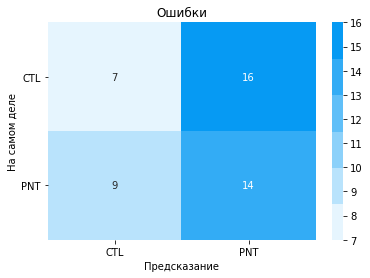

In [46]:
train_i, test_i = train_test_split(np.array(list(range(len(X)))), test_size=0.3)

controls = train_i[np.where(y[train_i] == 0)[0]]
patients = train_i[np.where(y[train_i] == 1)[0]]

y_pred = []
for i in test_i:
    control_dist = np.array([ D[i, j] for j in controls ]).mean()
    patient_dist = np.array([ D[i, j] for j in patients ]).mean()
    y_pred.append(int(patient_dist < control_dist))

show_accuracy(y[test_i], y_pred)

## Другие классификаторы

Как мы видели, классификация на 2 кластера не сработает. Будем разбивать на большее число кластеров, а потом отобразим их на нашу пару "контроль / пациент" следующим образом: для каждого кластера найдём, какого типа элементов больше, и к этому типу отнесём весь кластер.

In [10]:
def group_labels(labels, groups):
    if (min(len(groups), len(labels)) == 0):
        return np.array([])
    bins = np.array([[0 for j in range(max(groups) + 1)] for i in range(max(labels) + 1)])
    for group, label in zip(groups, labels):
        bins[label, group] += 1
    return np.argmax(bins, axis=1)

Точность:  0.616


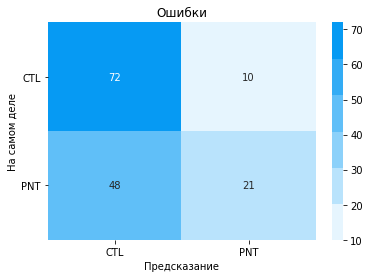

In [31]:
labels = AffinityPropagation(affinity='precomputed', random_state=None).fit_predict(-D)
show_accuracy(y, group_labels(labels, y)[labels])

Точность:  0.689


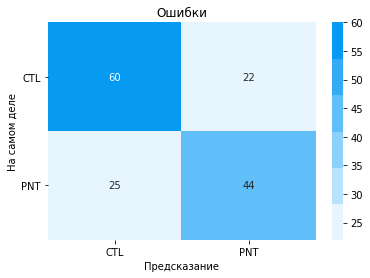

In [39]:
delta = 100
affinity = np.exp(- D ** 2 / (2. * delta ** 2))
labels = SpectralClustering(n_clusters=30, affinity='precomputed').fit_predict(affinity)
show_accuracy(y, group_labels(labels, y)[labels])

Точность:  0.656


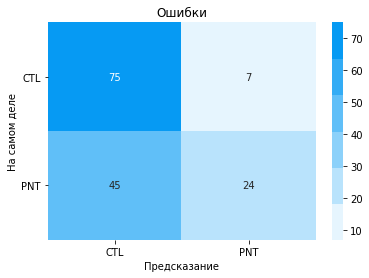

In [114]:
delta = 1.5
affinity = np.exp(-(D - D.mean()) ** 2 / (2. * delta ** 2))
labels = SpectralClustering(n_clusters=30, affinity='precomputed').fit_predict(affinity)
show_accuracy(y, group_labels(labels, y)[labels])

Шумы: 0.17218543046357615
Кластеров: 5
Точность:  0.528


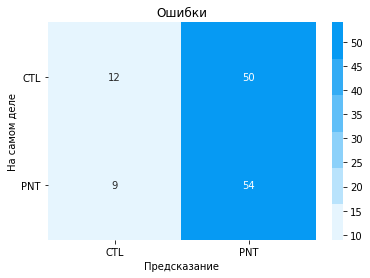

In [25]:
def dbscan(D, k):
    eps = np.partition(D, k, axis=1)[:,k].mean()
    labels = DBSCAN(eps=eps, min_samples=k, metric='precomputed').fit_predict(D)
    clean_y = y[labels != -1]
    clean_labels = labels[labels != -1]
    noise = sum(labels == -1) / len(labels)
    print('Шумы:', noise)
    print('Кластеров:', max(labels) + 1)
    if noise < 1:
        show_accuracy(clean_y, group_labels(clean_labels, clean_y)[clean_labels])
dbscan(D, 3)